In [1]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import joblib
from nltk import word_tokenize
from collections import Counter

from spellchecker import SpellChecker

import warnings
warnings.filterwarnings('ignore')

#pd.set_option('display.max_columns', None)  
#pd.set_option('display.expand_frame_repr', False)
#pd.set_option('max_colwidth', -1)

In [2]:
df = pd.read_csv('pre-processed.csv')

In [3]:
df.shape

(7200, 3)

In [4]:
print(df['preprocessed_news'][0])

katia abreu diz vai colocar expulsao moldura nao reclamar senadora katia abreu disse expulsao pmdb resultado acao cupula atual legenda segundo oportunista amanha vou botar moldura dourada expulsao porque maos onde veio atestado boa conduta curriculo pessoas expulsaram nao servem pais servem pais beneficios proprios disse katia abreu ue expulsao algo tao bom curriculo tanta choradeira katia sabemos motivo provavelmente katia nao valor pt partido ja deveria absorvido parece pt gostava katia somente ficasse entrincheirada dentro pmdb rebaixar demais resta katia ficar chorando pitangas todos cantos tempo ate momento pt nao cadastrou katia abreu fileiras situacao patetica agricultura dilma


In [5]:
df.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [6]:
df.isnull().sum()

index                0
label                0
preprocessed_news    0
dtype: int64

In [7]:
# tamanho da msg
df['size_msg'] = [len(msg) for msg in df['preprocessed_news']]

#qtde de palavras
df['number_words'] = [len(msg.split()) for msg in df['preprocessed_news']]

#maior palavra
df['big_word'] = [max(msg.split(), key= len) for msg in df['preprocessed_news']]

#tamanho da maior palavra
df['big_word'] = [len(msg) for msg in df.big_word]

---
#### Categorizar palavras
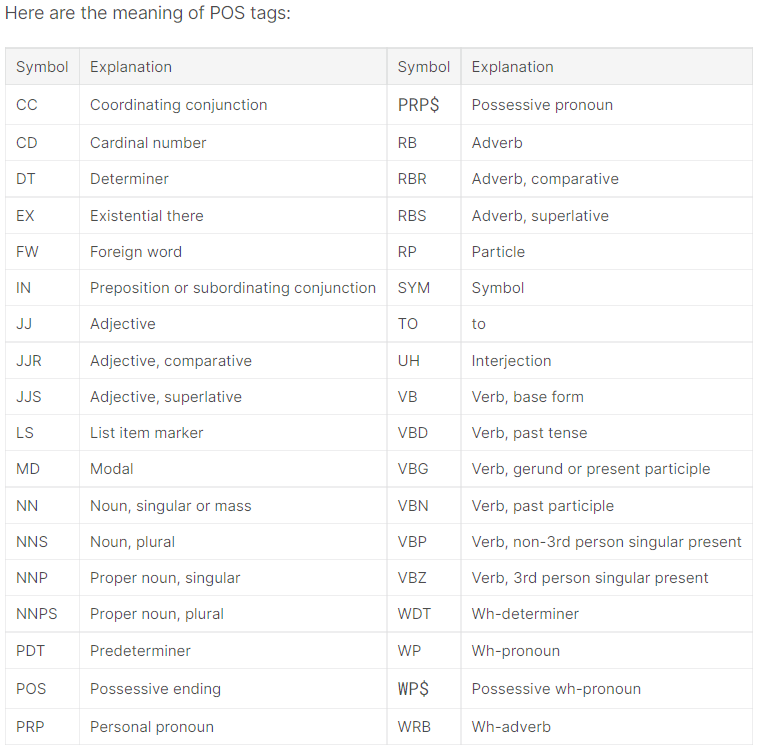

In [8]:
pos_tag = joblib.load('POS_tagger_brill.pkl')

df['category'] = [pos_tag.tag(word_tokenize(msg)) for msg in df['preprocessed_news']]

In [9]:
df['category'] = [[i[1] for i in item] for item in df['category']]

In [10]:
df['category'] = [Counter(line) for line in df['category']]
df.category[0]

Counter({'N': 39,
         'V': 22,
         'VAUX': 4,
         'NPROP': 8,
         'ADV': 8,
         'PCP': 4,
         'ADJ': 5,
         'PREP': 2,
         'KS': 1,
         'ADV-KS-REL': 1,
         'PROSUB': 2,
         'PROADJ': 2,
         'PDEN': 1})

In [11]:
dict_categ = df.category.to_dict()        
df_temp = pd.DataFrame.from_dict(dict_categ, orient='index')

df_temp.fillna(int(0), inplace=True)

for col in df_temp:
    df_temp[col] = df_temp[col].apply(lambda x: int(x))

df_temp['index'] = df['index']

df.drop(columns='category', inplace=True)

df = pd.merge(left=df, right=df_temp, how='inner', on='index')

In [12]:
df.head()

,index,label,preprocessed_news,size_msg,number_words,big_word,N,V,VAUX,NPROP,...,ADJ|EST,KC|[,N|AP,ART,PREP|+,N|DAD,ART|EST,VAUX|+,ADV|EST,PREP|[
0,0,fake,katia abreu diz vai colocar expulsao moldura n...,693,99,14,39,22,4,8,...,0,0,0,0,0,0,0,0,0,0
1,1,fake,ray peita bolsonaro conservador fake entrevist...,1072,143,14,45,32,7,19,...,0,0,0,0,0,0,0,0,0,0
2,2,fake,reinaldo azevedo desmascarado policia federal ...,1194,153,14,60,26,3,28,...,0,0,0,0,0,0,0,0,0,0
3,3,fake,relatorio assustador bndes mostra dinheiro pub...,2917,339,16,145,45,8,42,...,0,0,0,0,0,0,0,0,0,0
4,4,fake,radialista americano fala sobre pt vendem ilus...,467,66,12,25,21,1,3,...,0,0,0,0,0,0,0,0,0,0


#### Analisar palavras e erradas

In [13]:
spell = SpellChecker(language = 'pt')

In [ ]:
df['wrong_word'] = 0

for i, word in enumerate(df['preprocessed_news']):
    df['wrong_word'][i] = len(list(spell.unknown(word.split())))

In [18]:
df.groupby(['label']).mean()

,index,size_msg,number_words,big_word,N,V,VAUX,NPROP,ADV,PCP,...,KC|[,N|AP,ART,PREP|+,N|DAD,ART|EST,VAUX|+,ADV|EST,PREP|[,wrong_word
label,,,,,,,,,,,,,,,,,,,,,
fake,1799.5,816.406389,107.940833,13.296389,42.188333,20.466389,2.199167,15.389444,5.125833,5.290278,...,0.032778,0.014722,0.013889,0.007778,0.000833,0.005278,0.000278,0.000000,0.000000,12.054722
true,5399.5,4838.253889,624.935556,15.569167,248.931667,110.720833,12.473333,87.643333,29.666389,32.007500,...,0.219167,0.158611,0.056389,0.028333,0.004444,0.023889,0.003056,0.001111,0.000833,62.942222


---
#### Treino, Teste e Resultados

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

countvec = CountVectorizer(strip_accents='ascii', ngram_range=(1,2), max_features=5000)
tfidf = TfidfVectorizer(strip_accents='ascii', ngram_range=(1,2), max_features=5000)

In [16]:
from sklearn.model_selection import train_test_split

#convertendo classe para binario
df['_class'] = df['label'].apply(lambda x: 0 if x == 'fake' else 1)

y = df._class

X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_news'], y, test_size=0.3, random_state=42)

In [17]:
%%time
count_X_train = countvec.fit_transform(X_train)
tfidf_X_train = tfidf.fit_transform(X_train)

count_X_test = countvec.transform(X_test)
tfidf_X_test = tfidf.transform(X_test)

Wall time: 17.6 s


In [138]:
#palavras mais repetidas no corpus
vocab_df = pd.DataFrame.from_dict(countvec.vocabulary_, orient='index')
vocab_df.rename(columns={0:'number_rep'}, inplace=True)
vocab_df['number_rep'].sort_values(ascending=False).head(30)

zona sul          4999
zona oeste        4998
zona norte        4997
zona              4996
zika              4995
zeze              4994
zero              4993
zelotes           4992
ze                4991
zavascki          4990
zanin martins     4989
zanin             4988
youtube           4987
york              4986
xi jinping        4985
xi                4984
wyllys            4983
whatsapp          4982
wesley batista    4981
wesley            4980
weber             4979
washington        4978
wagner            4977
voz               4976
vou               4975
votou             4974
votos             4973
voto              4972
votaram           4971
votar             4970
Name: number_rep, dtype: int32

Accuracy with count vectorizer: 0.9555555555555556 

LienarSVC count Performance:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1087
           1       0.96      0.95      0.96      1073

    accuracy                           0.96      2160
   macro avg       0.96      0.96      0.96      2160
weighted avg       0.96      0.96      0.96      2160
 



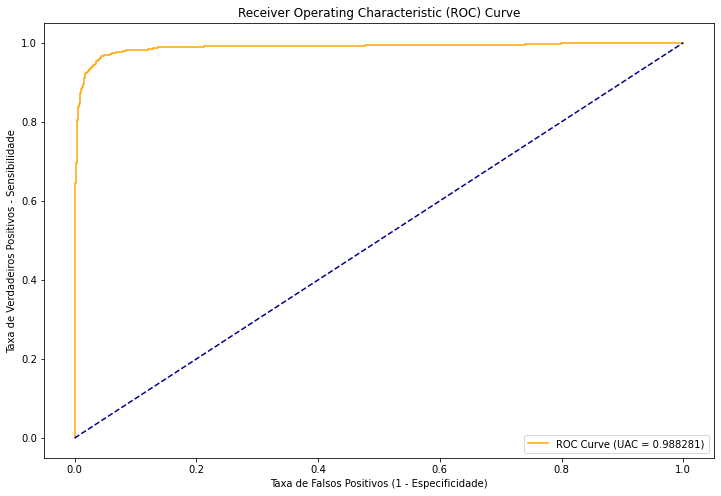

Predito     0     1   All
Real                     
0        1041    46  1087
1          50  1023  1073
All      1091  1069  2160 

Wall time: 1.35 s


In [19]:
%%time

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

svm = LinearSVC()
clf = CalibratedClassifierCV(svm)

svm.fit(count_X_train, y_train)
clf.fit(count_X_train, y_train)

preds = svm.predict(count_X_test)

y_proba = clf.predict_proba(count_X_test)[:,1]

print('Accuracy with count vectorizer:', metrics.accuracy_score(preds, y_test), '\n')
print("{} Performance:".format('LienarSVC count'))
print()
print(classification_report(y_test, preds), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc = metrics.roc_auc_score(y_test, y_proba)

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()

print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predito'], margins=True),'\n')

Accuracy with tfidf vectorizer: 0.9625 

LienarSVC tfidf Performance:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1087
           1       0.96      0.96      0.96      1073

    accuracy                           0.96      2160
   macro avg       0.96      0.96      0.96      2160
weighted avg       0.96      0.96      0.96      2160
 



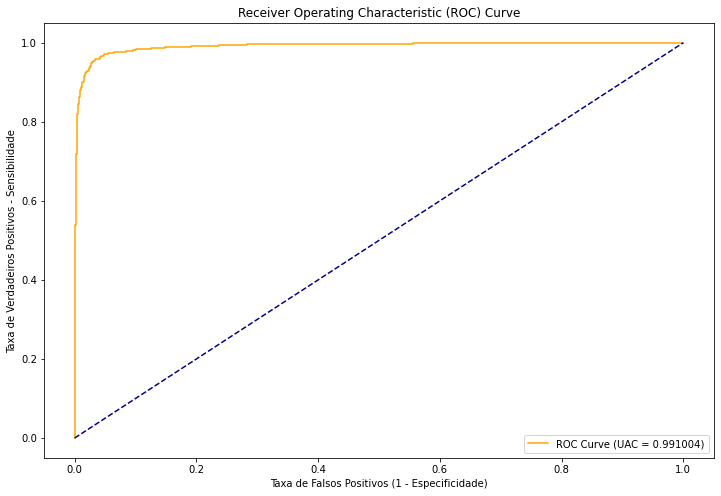

Predito     0     1   All
Real                     
0        1047    40  1087
1          41  1032  1073
All      1088  1072  2160 

Wall time: 435 ms


In [20]:
%%time

clf.fit(tfidf_X_train, y_train)
svm.fit(tfidf_X_train, y_train)

preds = svm.predict(tfidf_X_test)

y_proba = clf.predict_proba(tfidf_X_test)[:,1]

print('Accuracy with tfidf vectorizer:', metrics.accuracy_score(preds, y_test), '\n')
print("{} Performance:".format('LienarSVC tfidf'))
print()
print(classification_report(y_test, preds), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc = metrics.roc_auc_score(y_test, y_proba)

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()

print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predito'], margins=True),'\n')

Accuracy with count vectorizer: 0.9560185185185185 

RandomForestClassifier count Performance:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1087
           1       0.96      0.95      0.96      1073

    accuracy                           0.96      2160
   macro avg       0.96      0.96      0.96      2160
weighted avg       0.96      0.96      0.96      2160
 



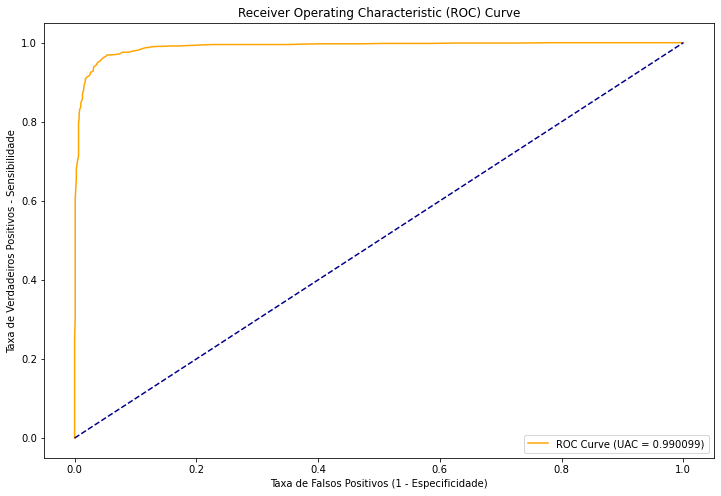

Predito     0     1   All
Real                     
0        1045    42  1087
1          53  1020  1073
All      1098  1062  2160 

Wall time: 4.16 s


In [21]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(count_X_train, y_train)

preds = rfc.predict(count_X_test)
y_proba = rfc.predict_proba(count_X_test)[:,1]

print('Accuracy with count vectorizer:', metrics.accuracy_score(preds, y_test), '\n')
print("{} Performance:".format('RandomForestClassifier count'))
print()
print(classification_report(y_test, preds), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc = metrics.roc_auc_score(y_test, y_proba)

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()

print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predito'], margins=True), '\n')

accuracy with tfidf vectorizer: 0.9537037037037037 

RandomForestClassifier tfidf Performance:

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1087
           1       0.95      0.96      0.95      1073

    accuracy                           0.95      2160
   macro avg       0.95      0.95      0.95      2160
weighted avg       0.95      0.95      0.95      2160
 



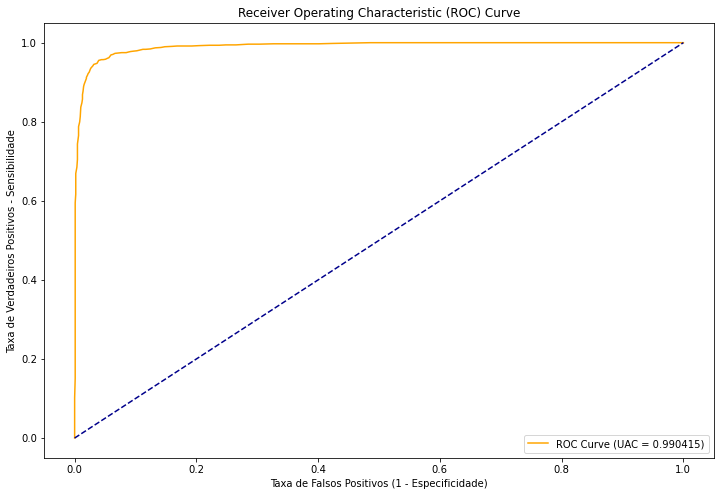

Predito     0     1   All
Real                     
0        1032    55  1087
1          45  1028  1073
All      1077  1083  2160 

Wall time: 4.45 s


In [22]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(tfidf_X_train, y_train)

preds = rfc.predict(tfidf_X_test)
y_proba = rfc.predict_proba(tfidf_X_test)[:,1]

print('accuracy with tfidf vectorizer:', metrics.accuracy_score(preds, y_test), '\n')
print("{} Performance:".format('RandomForestClassifier tfidf'))
print()
print(classification_report(y_test, preds), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc = metrics.roc_auc_score(y_test, y_proba)

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()

print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predito'], margins=True),'\n')

Accuracy with count vectorizer: 0.9324074074074075 

BernoulliNB count Performance:

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1087
           1       0.97      0.89      0.93      1073

    accuracy                           0.93      2160
   macro avg       0.94      0.93      0.93      2160
weighted avg       0.94      0.93      0.93      2160
 



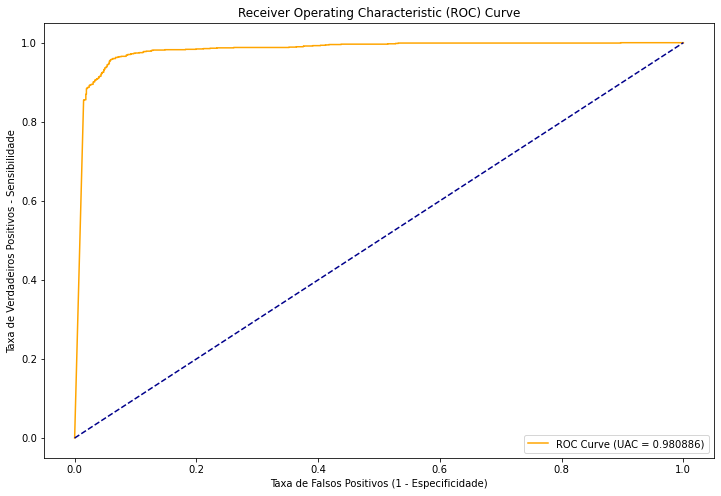

Predito     0    1   All
Real                    
0        1061   26  1087
1         120  953  1073
All      1181  979  2160 

Wall time: 206 ms


In [23]:
%%time
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(count_X_train, y_train)

preds = bnb.predict(count_X_test)
y_proba = bnb.predict_proba(count_X_test)[:,1]

print('Accuracy with count vectorizer:', metrics.accuracy_score(preds, y_test), '\n')
print("{} Performance:".format('BernoulliNB count'))
print()
print(classification_report(y_test, preds), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc = metrics.roc_auc_score(y_test, y_proba)

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()

print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predito'], margins=True), '\n')

Accuracy with tfidf vectorizer: 0.9324074074074075 


BernoulliNB tfidf Performance:

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1087
           1       0.97      0.89      0.93      1073

    accuracy                           0.93      2160
   macro avg       0.94      0.93      0.93      2160
weighted avg       0.94      0.93      0.93      2160
 



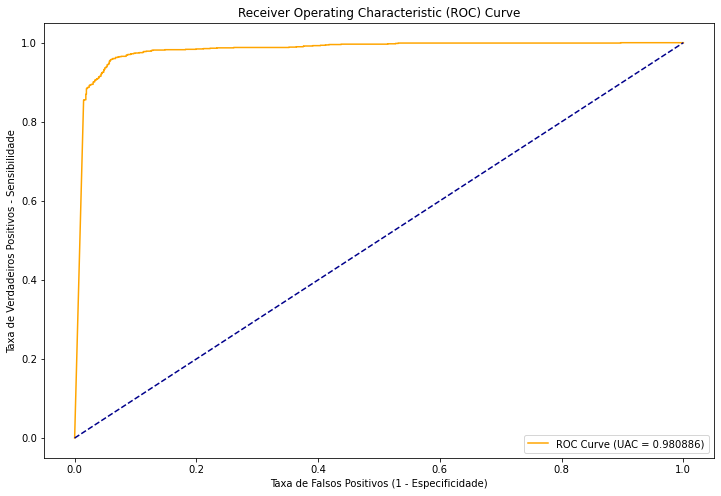

Predito     0    1   All
Real                    
0        1061   26  1087
1         120  953  1073
All      1181  979  2160 

Wall time: 189 ms


In [24]:
%%time

bnb.fit(tfidf_X_train, y_train)

preds = bnb.predict(tfidf_X_test)
y_proba = bnb.predict_proba(tfidf_X_test)[:,1]

print('Accuracy with tfidf vectorizer:', metrics.accuracy_score(preds, y_test), '\n\n')
print("{} Performance:".format('BernoulliNB tfidf'))
print()
print(classification_report(y_test, preds), '\n')

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc = metrics.roc_auc_score(y_test, y_proba)

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()

print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predito'], margins=True), '\n')

---
#### Explicação TF-IDF

* Term Frequency: Pontuação da frequência da palavra no documento atual.

* Inverse Document Frequency: Pontuação de quão rara a palavra é no documento.

Matematicamente falando:
TF = (número de vezes que o termo aparece em um documento) / (número de termos no documento)

IDF = log (N / n), em que N é o número de documentos e n é o número de documentos em que um termo apareceu.

O tf-idf é usado para pontuar a importância de uma palavra em um documento com base na frequência com que ela apareceu nesse documento.

Basicamente ele funciona da seguinte maneira:

Se uma palavra aparece com muita frequência em um documento, ela não deve ser importante então será atribuída uma pontuação baixa a ela.

Por outro lado, se uma palavra aparece com menos frequência nesse documento, então será atribuída uma pontuação mais alta a essa palavra. Tendo assim o efeito de destacar palavras distintas.

#### Outra explicação
TfidfVectorizer e CountVectorizer são métodos para converter dados de texto em vetores, pois o modelo pode processar apenas dados numéricos.

No CountVectorizer, contamos apenas o número de vezes que uma palavra aparece no documento, o que resulta em polarização em favor das palavras mais frequentes. isso acaba ignorando palavras raras que poderiam ter ajudado no processamento de nossos dados com mais eficiência.

Para superar isso, usamos o TfidfVectorizer .

No TfidfVectorizer , consideramos o peso geral do documento de uma palavra. Ajuda-nos a lidar com as palavras mais frequentes. Usando isso, podemos penalizá-los. O TfidfVectorizer pondera as contagens de palavras medindo a frequência com que aparecem nos documentos.